# Matching float profiles to satellite pixels
## Import Packages

In [1]:
import pandas as pd
import xarray as xr
import glob
#from pyhdf.SD import SD,SDC
import numpy as np
from datetime import *
from FromBieito.soccom_functions import *
from FromBieito.Calc_Chl import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

### Functions

In [2]:
from PyAstronomy import pyasl

In [81]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
# for a chosen depth range
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

In [82]:
# calculate the vertically integrated data column inventory using the composite trapezoidal rule
# input MLD as 4th karg
def integrate_wMLD(zi, data, start_depth, MLD):
    #n_profs = len(data)
    zi_start = abs(zi - start_depth).argmin() # find index of start depth
    zi_end =  abs(zi - MLD).argmin() # find index of end depth
    zi_struct = zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    #for n in range(0, len(data)):
    col_inv.append(np.trapz(data[:][~np.isnan(data[:])], zi_struct[:][~np.isnan(data[:])]))
    return col_inv

In [83]:
def integrate_chl(data):
    # Interpolate/get data set up
    zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
    chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
    chl_int[np.where(chl_int<0)]=0 # set negative values to 0
    
    ### Using a fixed lower limit
    # Integrate chl - total chl in upper 200m
    upperlim=0
    lowerlim=200
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated chl values between 0m-200m 
    
    ### Using the deepest MLD seen by the float
    # Integrate chl - total chl in upper ML - to deepest MLD seen by float
    upperlim=0
    lowerlim=np.nanmax(FLOAT.gr["mld"])
    print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated chl values between 0m-200m 

    ### Using the profile specific MLD 
    ## Don't use for later analysis atm, since there is chl below MLD in some years and floats
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    # using MLD calculated for each individual profile
    chl_T=chl_int.T # the interpolated chl from FLOAT.gr
    AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'] = np.full( nz, np.nan )
    for i in range(nz): #nz = length H2 (mld array) = number of profiles
        if np.isnan(H2[i]):
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.nan # in float used to write code, there were some nan for MLD because of no salinity values recorded
        else:
            lowerlim=H2[i]
            data=chl_T[i,:]
            AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'][i] = np.array(integrate_wMLD(zi, data, upperlim, lowerlim)) # integrate interpolated chl values between 0m-specificMLD

    ### The entire water column
    upperlim=0
    lowerlim=2000
    AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC'] = np.array(integrate(zi, chl_int.T, [upperlim, lowerlim])) # integrate interpolated nitrate values between 0m-200m 
    
    #return AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']
    return AllFloats                                      

In [152]:
def meanmax_chl(data):
    # Interpolate/get data set up
    zi = np.arange(0, 2005, 5) # 5 = 400 depth intervals between 0m to 2000m
    #or zi=self.gr["depth"] #which = np.arange(0,2000+dz,dz)
    chl_int = FLOAT.gr["Chl_a"] # interpolated chl values across zi depth intervals for all profiles
    chl_int[np.where(chl_int<0)]=0 # set negative values to 0
    
    ### Using a fixed lower limit
    H = 200 
    jh = np.where( FLOAT.gr["depth"]>= H)[0][0] # gets the depth index for the maxmum mixed layer
    profs=FLOAT.gr["Chl_a"].shape[1] #len(FLOAT.gr["Chl_a"].T)
    
    AllFloats[FLOAT.gr["WMO_code"]]['dMean_Chl']=[]
    AllFloats[FLOAT.gr["WMO_code"]]['dMax_Chl']=[]
    AllFloats[FLOAT.gr["WMO_code"]]['surf_Chl']=[]
    for nix in range(0,profs):
        #depth mean chl
        meanT=np.nanmean(chl_int[:jh,nix])
        maxT = np.nanmax(chl_int[:jh,nix])
        df = pd.DataFrame(chl_int[:jh,nix])
        firstT = df.loc[df.first_valid_index()]
        AllFloats[FLOAT.gr["WMO_code"]]['dMean_Chl'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['dMean_Chl'],meanT)
        AllFloats[FLOAT.gr["WMO_code"]]['dMax_Chl'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['dMax_Chl'],maxT)
        AllFloats[FLOAT.gr["WMO_code"]]['surf_Chl'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['surf_Chl'],firstT)
                       
    return AllFloats                                      

In [84]:
def chl_underornoice(data,yix):
    H2=FLOAT.gr["mld"]
    nz= len(H2)
    ## How much of the annual chl was present under ice?
    AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']=np.full(nz, np.nan)
    temp_IP=FLOAT.raw["Interpolated_Position"]
    AllFloats[FLOAT.gr["WMO_code"]]['InterPos']=np.int_(np.array(temp_IP.split()))
    AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno_IP']=np.full(nz, np.nan)
    for i in range(nz):
        test= np.isnan(FLOAT.gr["Temperature"][8,i]) #np.isnan(FLOAT.gr["Temperature"][0,i]) & np.isnan(FLOAT.gr["Temperature"][1,i]) & np.isnan(FLOAT.gr["Temperature"][2,i]) & np.isnan(FLOAT.gr["Temperature"][3,i]) & np.isnan(FLOAT.gr["Temperature"][4,i]) & #& np.isnan(FLOAT.gr["Temperature"][6,i]) & np.isnan(FLOAT.gr["Temperature"][7,i])
        temp_thres=np.nanmedian(FLOAT.gr["Temperature"][20:50,i])<(-1.78)
        if test.all() | temp_thres.all():
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]=0
            
        test2=i==AllFloats[FLOAT.gr["WMO_code"]]['InterPos']
        if test2.any() & temp_thres.all():
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno_IP'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno_IP'][i]=0
    #### Over the whole float timeseries
    ui=np.where(np.isnan(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    ui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][ui])
    nui=np.where(np.isfinite(FLOAT.gr["Chl_a"][0,:]) & np.isnan(FLOAT.gr["Chl_a"][1,:]) & np.isnan(FLOAT.gr["Chl_a"][2,:]) & np.isnan(FLOAT.gr["Chl_a"][3,:])) #& np.isnan(FLOAT.gr["Chl_a"][4,i]) #& np.isnan(FLOAT.gr["Chl_a"][5,i])
    nui_tot=np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'][nui])
    #print(np.nansum(chl_intr_dMLD))
    #print('approx % of chl under ice during float timeseries:', round(ui_tot/nui_tot*100,2),'%')
    
    #### get index for profiles that are in austral year, under ice and ice free
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=[]
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i]) #might be more efficient to make decy an np.int_ here so all the logical queries can be called at once?...
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        underice=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]>0
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if smol==tol:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],np.int_(i))#
        if smol==tol==underice:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],np.int_(i))
        if smol==tol==icefree:
            AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],np.int_(i))
    AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"])
    AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"])
    # exlude years with <34 profiles from next lot of calculations?
    ### Calculate how much Chl is present at specific times - whole year, under ice, when there's no ice
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    if len(AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"])>34: 
        #### Total in austral year
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"]]),6)
        #### Total under ice
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"]]),6)
        #### Total when ice-free
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"]]),6)
        #### proportion under ice for austral year
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
        #### Mean [Chl] in WC
        #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.round(np.nanmean(chl_intrWC[AllFloats['5904472'][yix]["aust_ix"]]),6)
    else:
        #### Total in austral year
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]=np.nan
        #### Total under ice
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"]=np.nan
        #### Total when ice-free
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"]=np.nan
        #### proportion under ice for austral year
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"]=np.nan
        AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]=np.nan
        #### Mean [Chl] in WC
        #AllFloats['5904472'][yix]["Mean_aus_chl"]=np.nan
    #for yix in range(startyear,endyear+1,1):
    print(yix,"under ice",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],3))
    #for yix in range(startyear,endyear+1,1):
    #    print(yix,"ice free",np.round(AllFloats['5904472'][yix]["Prop_icefree"],3))
        
    #return AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'],AllFloats[FLOAT.gr["WMO_code"]][yix]["aust_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["underice_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["icefree_ix"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_underice_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_icefree_chl"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_underice"],AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_icefree"]
    return AllFloats

In [85]:
def nosat_chl(data,yix):
    ## What is happening to the chl when the satellite isn't seeing the ice-free waters (from ~mid March)?
    Mar2214=datetime.datetime(2014,3,22)
    decmar14=pyasl.decimalYear(Mar2214)
    Mar3015=datetime.datetime(2015,3,30)
    decmar15=pyasl.decimalYear(Mar3015)
    Mar2116=datetime.datetime(2016,3,21)
    decmar16=pyasl.decimalYear(Mar2116)
    Mar2217=datetime.datetime(2017,3,22)
    decmar17=pyasl.decimalYear(Mar2217)
    Mar1418=datetime.datetime(2018,3,14)
    decmar18=pyasl.decimalYear(Mar1418)
    Mar1419=datetime.datetime(2019,3,14)
    decmar19=pyasl.decimalYear(Mar1419)
    Mar2120=datetime.datetime(2020,3,21)
    decmar20=pyasl.decimalYear(Mar2120)
    Mar1421=datetime.datetime(2021,3,14)
    decmar21=pyasl.decimalYear(Mar1421)
    

    AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=[]
    for i in range(len(FLOAT.gr["date_dt"])):
        decy = pyasl.decimalYear(FLOAT.gr["date_dt"][i])
        smol=decy>=(yix-0.5)
        tol=decy<(yix+0.5)
        icefree=AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno'][i]==0
        if yix==2014:
            mar=decy>=decmar14
        elif yix==2015:
            mar=decy>=decmar15
        elif yix==2016:
            mar=decy>decmar16
        elif yix==2017:
            mar=decy>decmar17
        elif yix==2018:
            mar=decy>decmar18
        elif yix==2019:
            mar=decy>decmar19
        elif yix==2020:
            mar=decy>decmar20
        elif yix==2021:
            mar=decy>decmar21
        if smol==tol==mar: #==icefree
            AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.append(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"],i)
        AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]=np.int_(AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"])
    
    #could add if rule: if len(AllFloats['5904472'][endyear]["aust_ix"])<34: continue... or [] =np.nan
    #### Total chl when satellite field of view reduces during March, but before ice returns
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]=np.round(np.nansum(AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'][AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]]),6)
    #### proportion under ice for austral year
    AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"]=AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_nosat_chl"]/AllFloats[FLOAT.gr["WMO_code"]][yix]["Tot_aus_chl"]
    print(yix,"no satellite coverage",np.round(AllFloats[FLOAT.gr["WMO_code"]][yix]["Prop_nosat"],3))
    return AllFloats

## Load in satellite data

In [86]:
rootdir = '../data/interim/'
satfiles = sorted(glob.glob(rootdir+"/chl*.nc")) #nans
print(satfiles)

chl_satellite=xr.open_dataset(satfiles[0])
#display(chl_satellite)

['../data/interim\\chl_2014onwards_nans.nc']


### Time is in matlab datenum 
= Need to convert to datetime

* Pos ask about how to put the values into the xarray dataset, but for now, is made as a separate variable (means a few extra lines later on)

In [87]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

In [88]:
nz= len(chl_satellite.date.values)
datezz=[]
for i in range(0,nz):
    datezz=np.append(datezz,datenum_to_datetime(chl_satellite.date.values[i]))
print(datezz[0])

2014-01-04 23:59:59.500003


In [89]:
#test isel command
#display(chl_satellite['npp'].isel(date=6,lat=500,lon=800))
chl_satellite['chl'].isel(date=6,lat=500,lon=800).values

array(0.22004464)

## Load in float data
One at a time for the moment

In [147]:
file_folder = "../data/raw/WGfloats/" # specify directory relative to location of notebook #SOCCOM_HiResQC_LIAR_21Dec2021_netcdf # WGfloats
###    For single float: 
#float_number = "5904471" #7900918 #9094/5904471 #5904397
#files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
#print(files)
#uses the function that reads and grids the data
#FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)
#print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))

###    For all floats:
files = sorted(glob.glob(file_folder+"/*.nc"))
print(files)
files1=files[0]
print(files1)

['../data/raw/WGfloats\\5904397_HRQC.nc', '../data/raw/WGfloats\\5904467_HRQC.nc', '../data/raw/WGfloats\\5904468_HRQC.nc', '../data/raw/WGfloats\\5904471_HRQC.nc', '../data/raw/WGfloats\\5904472_HRQC.nc', '../data/raw/WGfloats\\5905991_HRQC.nc', '../data/raw/WGfloats\\5905992_HRQC.nc', '../data/raw/WGfloats\\5905993_HRQC.nc', '../data/raw/WGfloats\\5905994_HRQC.nc', '../data/raw/WGfloats\\5905995_HRQC.nc', '../data/raw/WGfloats\\5906033_HRQC.nc', '../data/raw/WGfloats\\5906034_HRQC.nc']
../data/raw/WGfloats\5904397_HRQC.nc


### Calculate depth integrated chl to compare to satellite NPP

In [91]:
import warnings
warnings.filterwarnings('ignore')
# because next cell has warnings for each iteration -- ask someone about them in future

In [92]:
#make structure for floats 
AllFloats = {}
float_ID=[]
for f in files: #[files1]: #files:
    FLOAT = grids_one_buoy(f,display_info = False, DO_ml_crit = 2.5, clear_short = True,dz=1) #load in float data 
    AllFloats[FLOAT.gr["WMO_code"]] = {} # blank class for float
    AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']=FLOAT.gr["date_dt"]
    AllFloats[FLOAT.gr["WMO_code"]]['lon']=FLOAT.gr["Lon"]
    AllFloats[FLOAT.gr["WMO_code"]]['lat']=FLOAT.gr["Lat"]
    float_ID=np.append(float_ID,FLOAT.gr["WMO_code"])
    print(float_ID)
    #upperlim=0
    #lowerlim=np.nanmax(FLOAT.gr["mld"])
    #print(FLOAT.gr["WMO_code"],"Deepest mixed layer: %1.0f m"%(lowerlim))
    
    #AllFloats[FLOAT.gr["WMO_code"]]['chl_intr200'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intr_dMLD'],AllFloats[FLOAT.gr["WMO_code"]]['dint_chla'],AllFloats[FLOAT.gr["WMO_code"]]['chl_intrWC']=integrate_chl(FLOAT)
    AllFloats=integrate_chl(FLOAT)
    AllFloats=meanmax_chl(FLOAT)
    
    ##### Get year range
    startyear=FLOAT.gr["date_dt"][0].year
    endyear=FLOAT.gr["date_dt"][-1].year
    #print(startyear, '-', endyear)
    #yearrange=range(startyear,endyear+1)
    #print(yearrange)
    nosat_temp=[] # getting 0/1 for no sat coverage at the end of the year for plotting later
    
    for yix in np.arange(startyear,endyear+1):
        #print(yix)
        AllFloats[FLOAT.gr["WMO_code"]][yix] ={}
        AllFloats=chl_underornoice(FLOAT,yix)
        AllFloats=nosat_chl(FLOAT,yix)
        
        nosat_temp=(np.append(nosat_temp,AllFloats[FLOAT.gr["WMO_code"]][yix]["no_sat"]))
    
    AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno']=np.full(len(AllFloats[FLOAT.gr["WMO_code"]]['dates_dt']), np.nan) # getting 0/1 for no sat coverage at the end of the year for plotting later
    for i in range(0,len(AllFloats[FLOAT.gr["WMO_code"]]['dates_dt'])): # getting 0/1 for no sat coverage at the end of the year for plotting later
        if (len(list(filter (lambda x : x == i, nosat_temp))) > 0):
            #print(i)
            AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno'][i]=1
        else:
            AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno'][i]=0
    
    ##### Get satellite values for each profile for each float
    fz=len(FLOAT.gr["date_dt"])
    ## Select satellite pixel and get NPP value
    AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles']=np.full(fz,np.nan)
    AllFloats[FLOAT.gr["WMO_code"]]['satnan']=np.full(fz,np.nan)
    AllFloats[FLOAT.gr["WMO_code"]]['sat_date']=[]
    for fix in range(0,fz):
        #print(FLOAT.gr["date_dt"][fix])
        #print(FLOAT.gr["Lat"][0])
        #print(FLOAT.gr["Lon"][0])
        float_date = FLOAT.gr["date_dt"][fix]
        # get all differences with date as values 
        cloz_dict = { 
          abs(float_date.timestamp() - date.timestamp()) : date 
          for date in datezz}
        # extracting minimum key using min()
        AllFloats[FLOAT.gr["WMO_code"]]['sat_date'] = np.append(AllFloats[FLOAT.gr["WMO_code"]]['sat_date'],cloz_dict[min(cloz_dict.keys())])
        #print("Nearest date from float date : " + str(sat_date))
        #date_ix=[]
        date_ix=np.where(datezz==AllFloats[FLOAT.gr["WMO_code"]]['sat_date'][fix])
        date_sel=chl_satellite['date'][date_ix]
        
        #AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'][fix]=chl_satellite['chl'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values
        AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'][fix]=chl_satellite['chl'].sel(date=date_sel,lat=FLOAT.gr["Lat"][fix],lon=FLOAT.gr["Lon"][fix],method='nearest').values
        #AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'][fix]=chl_satellite['chl'].sel(date=date_sel,lat=-50,lon=25,method='nearest').values # just choosing a randon single location to check code
        
    AllFloats[FLOAT.gr["WMO_code"]]['satnan']=np.zeros_like(AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles']) #1 where there is nan for satellite NPP value
    AllFloats[FLOAT.gr["WMO_code"]]['satnan'][np.isnan(AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'])]=1
    
    #AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'][np.where(AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles']<0)]=np.nan
    display(AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'])

['5904397']
5904397 Deepest mixed layer: 142 m
2015 under ice nan
2015 no satellite coverage nan
2016 under ice 0.081
2016 no satellite coverage 0.217
2017 under ice 0.053
2017 no satellite coverage 0.32
2018 under ice 0.057
2018 no satellite coverage 0.25
2019 under ice 0.085
2019 no satellite coverage 0.26
2020 under ice nan
2020 no satellite coverage nan


array([1.03603637, 0.69236994, 0.16967089, 0.46366775, 0.26016584,
       0.15631475, 0.12825471, 0.16512677,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.44969377, 0.40388083, 0.36881208, 0.25347841, 0.16574442,
       0.09117682, 0.11701246, 0.12848321, 0.12848321,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.22324835, 0.17037994, 0.23897   ,
       0.28838208, 0.22753191, 0.29360181, 0.21790262, 0.27097

['5904397' '5904467']
5904467 Deepest mixed layer: 141 m
2014 under ice nan
2014 no satellite coverage nan
2015 under ice nan
2015 no satellite coverage nan
2016 under ice 0.051
2016 no satellite coverage 0.091
2017 under ice 0.062
2017 no satellite coverage 0.119
2018 under ice 0.096
2018 no satellite coverage 0.302
2019 under ice nan
2019 no satellite coverage nan


array([       nan,        nan,        nan, 0.78779191, 0.44775379,
       0.63135511, 0.27675587, 0.56052911, 0.3461512 , 0.20555925,
       0.2042208 , 0.12874694,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.6460976 ,
       0.60618806, 0.69745213, 0.28400579, 0.24042499, 0.29361612,
       0.13085178, 0.13551228,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.20886606, 0.17816441, 0.39730784, 0.73819

['5904397' '5904467' '5904468']
5904468 Deepest mixed layer: 178 m
2015 under ice nan
2015 no satellite coverage nan
2016 under ice 0.021
2016 no satellite coverage 0.065
2017 under ice 0.026
2017 no satellite coverage 0.15
2018 under ice 0.035
2018 no satellite coverage 0.287
2019 under ice 0.013
2019 no satellite coverage 0.146
2020 under ice nan
2020 no satellite coverage nan


array([1.10374606, 0.7968055 , 0.49297494, 0.77684909, 0.16132003,
       0.24069282, 0.13838531,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.53565109,
       1.15229309, 0.77527839, 0.57051873, 0.39791241, 0.55835199,
       0.27251139, 0.15961874, 0.1196061 ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.49022824, 1.66666782, 0.97404635,
       1.10498118, 0.46372619, 0.34913   , 0.3380999 , 0.18189

['5904397' '5904467' '5904468' '5904471']
5904471 Deepest mixed layer: 209 m
2014 under ice nan
2014 no satellite coverage nan
2015 under ice nan
2015 no satellite coverage nan
2016 under ice 0.027
2016 no satellite coverage 0.095
2017 under ice 0.042
2017 no satellite coverage 0.15
2018 under ice 0.043
2018 no satellite coverage 0.165
2019 under ice nan
2019 no satellite coverage nan


array([       nan,        nan,        nan,        nan, 0.71341062,
       0.66425234, 0.29039133, 0.34068862, 0.32477421, 0.10618418,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 2.47361207, 0.71735376,
       0.738424  , 0.85038656, 0.24041191, 0.32657379, 0.16202866,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.19066323, 0.18084507, 0.33633158, 0.4403832 , 0.31244

['5904397' '5904467' '5904468' '5904471' '5904472']
5904472 Deepest mixed layer: 145 m
2015 under ice nan
2015 no satellite coverage nan
2016 under ice 0.081
2016 no satellite coverage 0.125
2017 under ice 0.02
2017 no satellite coverage 0.018
2018 under ice 0.067
2018 no satellite coverage 0.215
2019 under ice nan
2019 no satellite coverage nan


array([0.17675942, 0.17099717, 0.26535738, 0.11838266, 0.18098308,
       0.25039053,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.17744528, 0.31101516,
       0.45263174, 0.45225999, 0.50005269, 0.45921972, 0.39936697,
       0.3136394 , 0.32016444,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.15613495, 0.47279444, 3.82783747,
       3.61626077, 3.35843349, 1.70172191, 0.25430024, 0.16694

['5904397' '5904467' '5904468' '5904471' '5904472' '5905991']
5905991 Deepest mixed layer: 135 m
2019 under ice nan
2019 no satellite coverage nan
2020 under ice 0.073
2020 no satellite coverage 0.13
2021 under ice 0.018
2021 no satellite coverage 0.087


array([       nan,        nan, 0.09789719, 0.11034112, 0.08618299,
       0.10043527, 0.11383637,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.21300955,        nan, 0.12525238, 0.11091971, 0.10184207,
       0.10127369, 0.13652904, 0.13562176, 0.13403051,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.42945343,        nan,
              nan, 0.38177684, 1.84670508, 1.14309728, 0.99636

['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992']
5905992 Deepest mixed layer: 188 m
2019 under ice nan
2019 no satellite coverage nan
2020 under ice 0.046
2020 no satellite coverage 0.07
2021 under ice nan
2021 no satellite coverage nan


array([0.30595279, 0.15880081, 0.28102422, 0.18949963, 0.11324532,
       0.11324532, 0.08230345,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.42476317,        nan,
       0.33216068, 0.28742275, 0.32513759, 0.27097932, 0.22444424,
       0.10090202, 0.10878406, 0.13125058,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.53166819, 0.41356656, 0.63366

['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993']
5905993 Deepest mixed layer: 530 m
2019 under ice nan
2019 no satellite coverage nan
2020 under ice nan
2020 no satellite coverage nan


array([0.40996346, 0.45148155, 1.63652575,        nan, 2.50029588,
       1.47644627,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993' '5905994']
5905994 Deepest mixed layer: 176 m
2019 under ice nan
2019 no satellite coverage nan
2020 under ice 0.015
2020 no satellite coverage 0.026
2021 under ice nan
2021 no satellite coverage nan


array([        nan,  0.26240209,  0.12746052,  0.06988409,  0.16531959,
        0.11418503,  0.11418503,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        4.81052351,  5.89184523,  7.87511969, 48.83648682,  1.38166094,
        0.89138687,  1.77138245,  1.09098065,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993' '5905994' '5905995']
5905995 Deepest mixed layer: 139 m
2019 under ice nan
2019 no satellite coverage nan
2020 under ice 0.058
2020 no satellite coverage 0.12
2021 under ice nan
2021 no satellite coverage nan


array([1.03686464, 0.46868566, 0.56106287, 0.27503487, 0.2112751 ,
       0.20886049, 0.18058325, 0.1474092 , 0.20002411,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.09665535, 0.33330083, 0.15789904, 0.5966146 ,
       0.24459681, 0.56651372, 0.27682683, 0.48345733,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.28564

['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993' '5905994' '5905995' '5906033']
5906033 Deepest mixed layer: 129 m
2019 under ice nan
2019 no satellite coverage nan
2020 under ice 0.02
2020 no satellite coverage 0.03
2021 under ice nan
2021 no satellite coverage nan


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.6050297 , 0.76402068, 1.37581384, 0.57326365,
       0.42108303, 0.38364679, 0.12998909, 0.12321109, 0.16268927,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 1.90749121, 2.9762516 , 0.57766163, 1.93588614,
       0.31576014,        nan,        nan,        nan,        

['5904397' '5904467' '5904468' '5904471' '5904472' '5905991' '5905992'
 '5905993' '5905994' '5905995' '5906033' '5906034']
5906034 Deepest mixed layer: 115 m
2019 under ice nan
2019 no satellite coverage nan
2020 under ice 0.055
2020 no satellite coverage 0.166
2021 under ice 0.081
2021 no satellite coverage 0.315


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.24169905, 0.22145294, 0.34424677, 0.33469966,
       0.34975436, 0.44535661, 0.2437195 , 0.24881968, 0.09490582,
       0.17248958,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.12667899, 0.11174522,
       0.15117839, 0.15276577, 0.12791978, 0.12748788, 0.28558999,
       0.0859763 , 0.0859763 ,        nan,        nan,        

(188,)
(2001,)
(2001, 188)


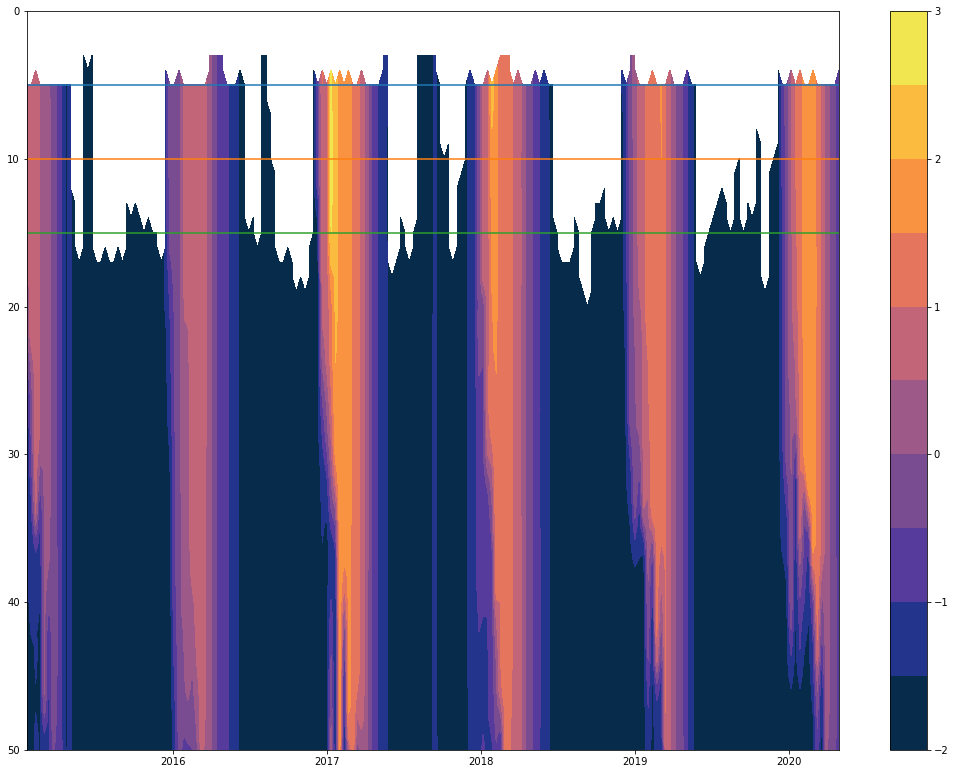

In [47]:
fig = plt.figure(figsize = (30,38))
ax0 = fig.add_axes([0.57,0.35,0.47,0.27])
#num=np.arange(1,234,1)
print(FLOAT.gr["date"].shape)
print(FLOAT.gr["depth"].shape)
print(FLOAT.gr["Chl_a"].shape)
cfT=ax0.contourf(FLOAT.gr["date_dt"],FLOAT.gr["depth"][0:320],FLOAT.gr["Temperature"][0:320],10, cmap = cmocean.cm.thermal)
ax0.set_ylim(0,50)
plt.gca().invert_yaxis()
cb = fig.colorbar(cfT)

ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,5)) #i=1
ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,10)) #i=2
ax0.plot(FLOAT.gr["date_dt"],np.full(FLOAT.gr["date"].size,15)) #i=3



Text(0, 0.5, '$\\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')

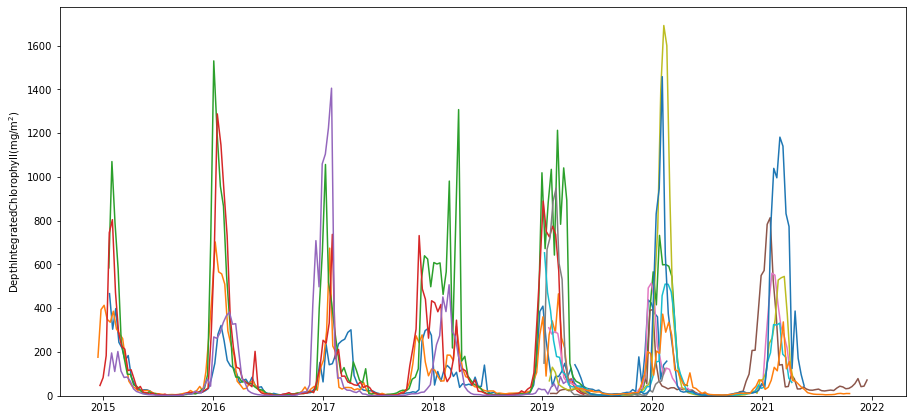

In [93]:
#Plot
#fig = plt.subplots(figsize = (20, 8))
#plt.plot(AllFloats[FLOAT.gr["WMO_code"]]['sat_date'],AllFloats[FLOAT.gr["WMO_code"]]['Chl_atprofiles'], c='black')
#plt.ylabel('NPP (mg/m2/d1)')
#plt.xlabel('Date')

fig = plt.figure(figsize = (25,20))
ax0 = fig.add_axes([0.07,0.65,0.47,0.27])
for f_ix in range(0,len(float_ID)):
    ID=float_ID[f_ix]
    chl=AllFloats[ID]['chl_intr200']
    date=AllFloats[ID]['dates_dt']
    
    ax0.plot(date,chl)
ax0.set_ylim(0)
ax0.set_ylabel('$\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')
    
#ax1=ax0.twinx()
#ax1.plot(sat_date,Chl_atprofiles, c='black',linewidth=3)
#ax1.set_ylabel('$\mathregular {Daily NPP Rates (mgC/m^2/d^1)}$')

#underice4,=ax0.plot(FLOAT.gr["date_dt"],(AllFloats[FLOAT.gr["WMO_code"]]['underice_yesno']*(np.nanmax(chl))),c='lightblue',ls=':',lw=3)
#nosat__,=ax0.plot(FLOAT.gr["date_dt"],(AllFloats[FLOAT.gr["WMO_code"]]['no_sat_yesno']*(np.nanmax(chl))),c='orange',ls=':',lw=3)

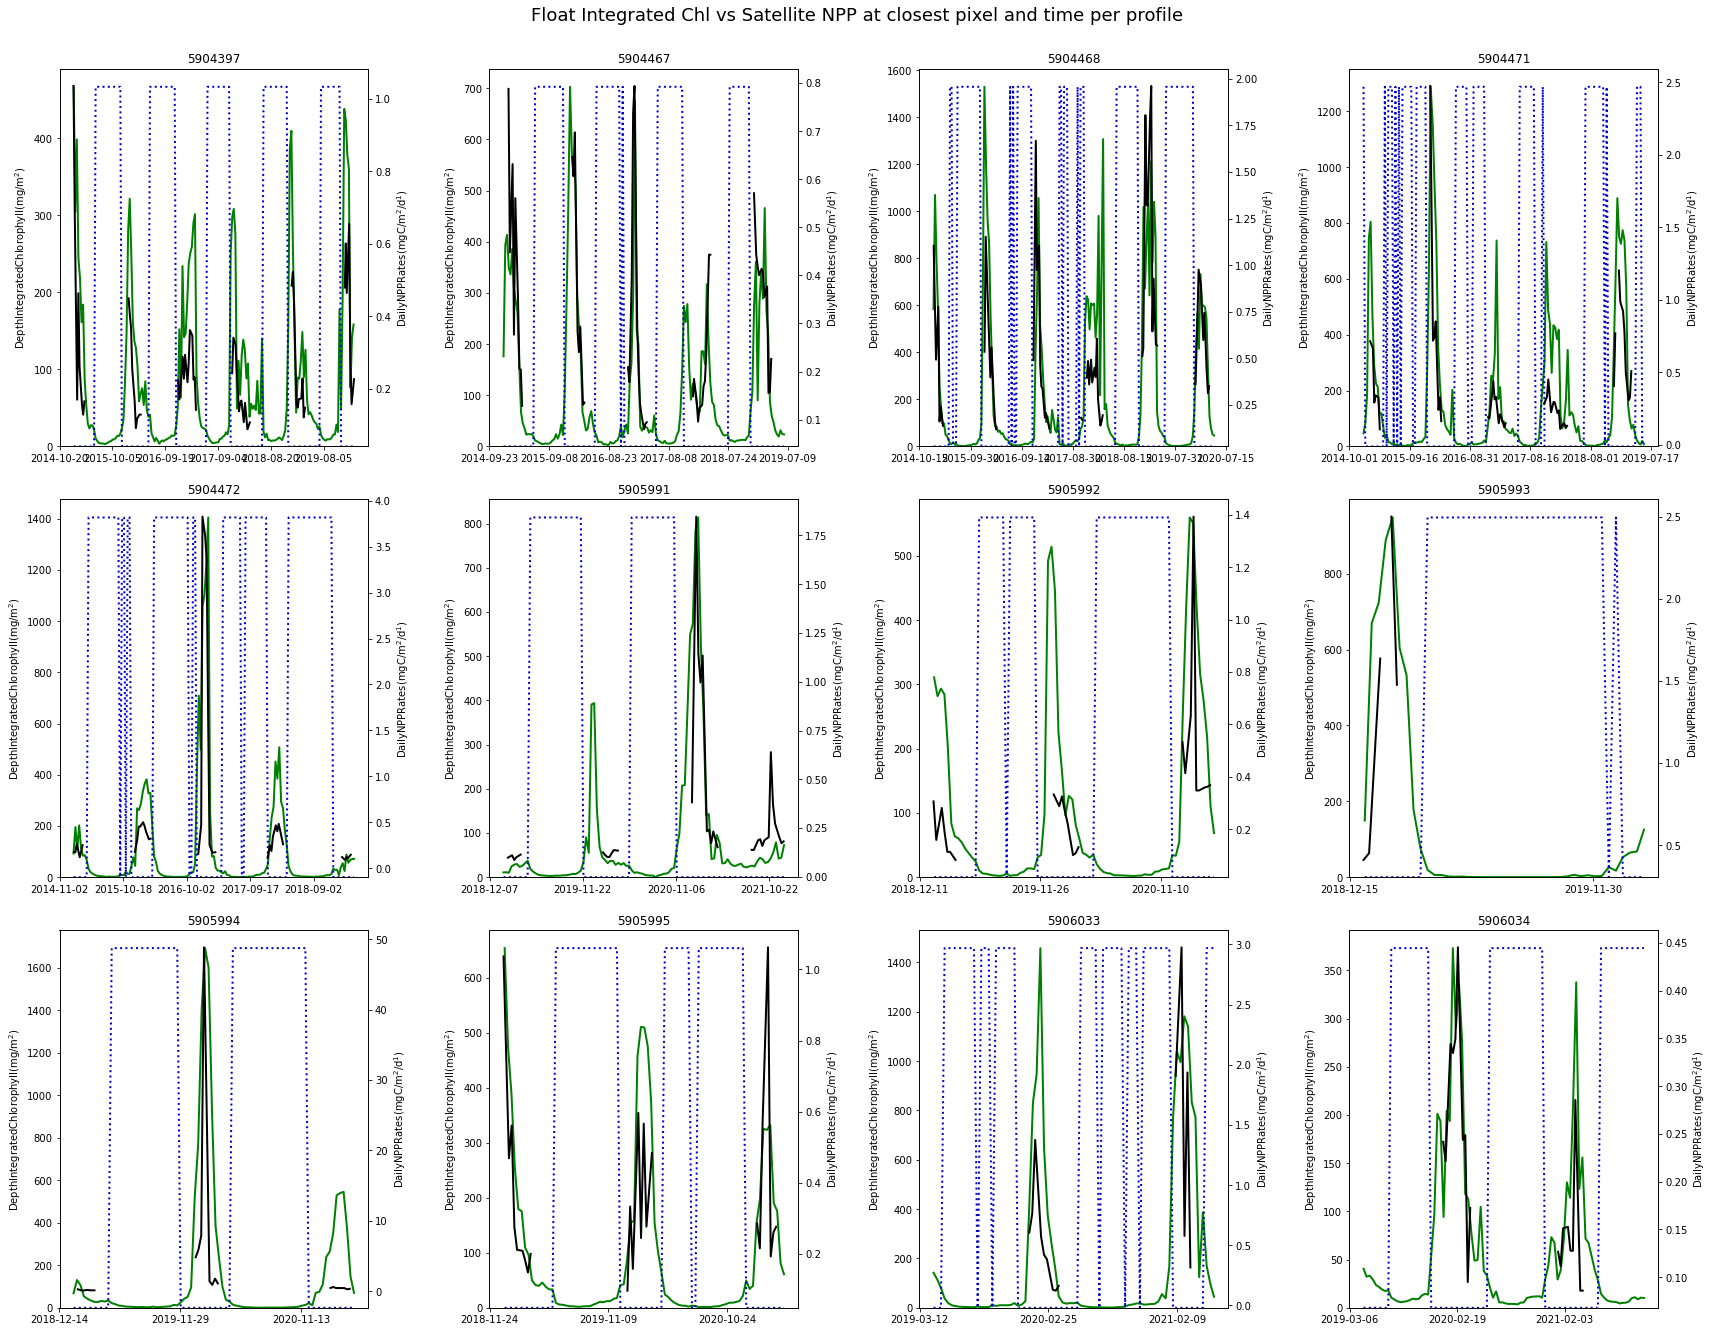

In [95]:
plt.figure(figsize=(25, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Float Integrated Chl vs Satellite NPP at closest pixel and time per profile", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, float_ in enumerate(float_ID):
    # add a new subplot iteratively
    ax = plt.subplot(3,np.int(float_ID.size/3),n+1)#(1,1,n+1)#(3, 4, n + 1)
    plt.title(float_)
    #print(n,float_)
    #ID=float_ID[f_ix]
    chl=AllFloats[float_]['chl_intr200']
    date=AllFloats[float_]['dates_dt']
    plt.plot(date,chl,c='green',lw=2)
    plt.plot(date,np.max(chl)*AllFloats[float_]['underice_yesno'],c='mediumblue',ls=':',lw=2)
    ax.set_ylim(0)
    ax.set_ylabel('$\mathregular {Depth Integrated Chlorophyll (mg/m^2)}$')
    
    ax1=ax.twinx()
    ax1.plot(AllFloats[float_]['sat_date'],AllFloats[float_]['Chl_atprofiles'], c='black',linewidth=2)
    ax1.set_ylabel('$\mathregular {Daily NPP Rates (mgC/m^2/d^1)}$')
    
    start, end = ax.get_xlim()
    #print(start,end)
    ax.xaxis.set_ticks(np.arange(start, end, 350))
    
plt.tight_layout(pad=5, w_pad=2, h_pad=2)

In [51]:
float_ID.size

3

### What fraction of profiles don't have corresponding satellite values 
(for whatever reason - ice coverage, pos cloud coverage, not enough light for satellite) 

(note: float location estimated when it is under ice, but can also expect that satellite doesn't have values for where float probably is because it will also be seeing ice)

In [54]:
#### get index for profiles that don't have satellite coverage
    ### FROM: AllFloats[FLOAT.gr["WMO_code"]]['satnan']
#
for n, float_ in enumerate(float_ID):
    startyear=AllFloats[float_]["dates_dt"][0].year
    endyear=AllFloats[float_]["dates_dt"][-1].year
    AllFloats[float_]["Av_prop_numprofs_satnan"]=[]
    temp=[]
    #print(startyear, '-', endyear)
    for yix in range(startyear,endyear+1,1):
        #AllFloats[float_][yix]["aust_ix"]=[] # made earlier
        AllFloats[float_][yix]["satnan_ix"]=[]
        AllFloats[float_][yix]["sat_ix"]=[]
        for i in range(len(AllFloats[float_]["dates_dt"])):
            decy = pyasl.decimalYear(AllFloats[float_]["dates_dt"][i]) 
            smol=decy>=(yix-0.5)
            tol=decy<(yix+0.5)
            satnan=AllFloats[float_]['satnan'][i]>0
            sat=AllFloats[float_]['satnan'][i]==0
            if smol==tol==satnan:
                AllFloats[float_][yix]["satnan_ix"]=np.append(AllFloats[float_][yix]["satnan_ix"],i)
            if smol==tol==sat:
                AllFloats[float_][yix]["sat_ix"]=np.append(AllFloats[float_][yix]["sat_ix"],i)
        AllFloats[float_][yix]["satnan_ix"]=np.int_(AllFloats[float_][yix]["satnan_ix"])
        AllFloats[float_][yix]["sat_ix"]=np.int_(AllFloats[float_][yix]["sat_ix"])
        
        #### Total when no corresponding sat data
        AllFloats[float_][yix]["Tot_satnan_chl"]=np.round(np.nansum(AllFloats[float_]['chl_intr200'][AllFloats[float_][yix]["satnan_ix"]]),6)
        #### Total when sat data matches up
        AllFloats[float_][yix]["Tot_sat_chl"]=np.round(np.nansum(AllFloats[float_]['chl_intr200'][AllFloats[float_][yix]["sat_ix"]]),6)
        #### proportion for austral year
        AllFloats[float_][yix]["Prop_satnan"]=np.round(AllFloats[float_][yix]["Tot_satnan_chl"]/AllFloats[float_][yix]["Tot_aus_chl"],6)
        AllFloats[float_][yix]["Prop_sat"]=np.round(AllFloats[float_][yix]["Tot_sat_chl"]/AllFloats[float_][yix]["Tot_aus_chl"],6)
        
        #### Number of profiles in austral year
        AllFloats[float_][yix]["numprofs_tot"]=len(AllFloats[float_][yix]["aust_ix"])
        #### Number of profiles without corresponding sat values
        AllFloats[float_][yix]["numprofs_satnan"]=len(AllFloats[float_][yix]["satnan_ix"])
        #### Number of profiles with corresponding sat values
        AllFloats[float_][yix]["numprofs_sat"]=len(AllFloats[float_][yix]["sat_ix"])
        
        if AllFloats[float_][yix]["numprofs_tot"]>0:
            AllFloats[float_][yix]["Prop_numprofs_satnan"]=AllFloats[float_][yix]["numprofs_satnan"]/AllFloats[float_][yix]["numprofs_tot"]
        else:
            continue
        temp=np.append(temp,AllFloats[float_][yix]["Prop_numprofs_satnan"])
        print('Proportion of Integrated Chl observed on no sat profiles: Float',float_,yix,'=',np.round(AllFloats[float_][yix]["Prop_satnan"],3))
    AllFloats[float_]["Av_prop_numprofs_satnan"]=np.round(np.nanmean(temp),6)
    print('Float',float_,'Av proportion of number of profiles where satellite values were NaN:',AllFloats[float_]["Av_prop_numprofs_satnan"],'+/-',np.round(np.std(temp),6))
    
    
          

Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2015 = nan
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2016 = 0.338
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2017 = 0.131
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2018 = 0.347
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2019 = 0.353
Proportion of Integrated Chl observed on no sat profiles: Float 5904397 2020 = nan
Float 5904397 Av proportion of number of profiles where satellite values were NaN: 0.654302 +/- 0.078484
Proportion of Integrated Chl observed on no sat profiles: Float 5904467 2015 = nan
Proportion of Integrated Chl observed on no sat profiles: Float 5904467 2016 = 0.454
Proportion of Integrated Chl observed on no sat profiles: Float 5904467 2017 = 0.185
Proportion of Integrated Chl observed on no sat profiles: Float 5904467 2018 = 0.434
Proportion of Integrated Chl observed on no sat pro

In [55]:
floatav=[]
for n, float_ in enumerate(float_ID):
    startyear=AllFloats[float_]["dates_dt"][0].year
    endyear=AllFloats[float_]["dates_dt"][-1].year
    #print(startyear, '-', endyear)
    temp=[]
    
    for yix in range(startyear,endyear+1,1):
        temp=np.append(temp,AllFloats[float_][yix]["Prop_satnan"])
    floatav=np.append(floatav,np.nanmean(temp))
#print(floatav)
floatallav=np.nanmean(floatav)
floatallstd=np.nanstd(floatav)
print('Av chl missed where satellite values were NaN:',np.round(floatallav,3),'+/-',np.round(floatallstd,3))

Av chl missed where satellite values were NaN: 0.264 +/- 0.091


In [56]:
floatav=[]
for n, float_ in enumerate(float_ID):
    startyear=AllFloats[float_]["dates_dt"][0].year
    endyear=AllFloats[float_]["dates_dt"][-1].year
    #print(startyear, '-', endyear)
    temp=[]
    
    for yix in range(startyear,endyear+1,1):
        temp=np.append(temp,AllFloats[float_][yix]["Prop_underice"])
    floatav=np.append(floatav,np.nanmean(temp))
#print(floatav)
floatallav=np.nanmean(floatav)
floatallstd=np.nanstd(floatav)
print('Av chl missed when there is ice:',np.round(floatallav,3),'+/-',np.round(floatallstd,3))

Av chl missed when there is ice: 0.054 +/- 0.022


In [57]:
floatav=[]
for n, float_ in enumerate(float_ID):
    startyear=AllFloats[float_]["dates_dt"][0].year
    endyear=AllFloats[float_]["dates_dt"][-1].year
    #print(startyear, '-', endyear)
    temp=[]
    
    for yix in range(startyear,endyear+1,1):
        temp=np.append(temp,AllFloats[float_][yix]["Prop_nosat"])
    floatav=np.append(floatav,np.nanmean(temp))
#print(floatav)
floatallav=np.nanmean(floatav)
floatallstd=np.nanstd(floatav)
print('Av chl missed where there is no light :',np.round(floatallav,3),'+/-',np.round(floatallstd,3))



Av chl missed where there is no light : 0.198 +/- 0.045


## Match-up

### Get info from a single profile

In [7]:
print(FLOAT.gr["date_dt"][0])
print(FLOAT.gr["Lat"][0])
print(FLOAT.gr["Lon"][0])


2014-12-21 12:45:59.999996
-10000000000.0
-10000000000.0


### Select satellite pixel and get NPP value

In [8]:
float_date = FLOAT.gr["date_dt"][0]
# get all differences with date as values 
cloz_dict = { 
  abs(float_date.timestamp() - date.timestamp()) : date 
  for date in datezz}
# extracting minimum key using min()
sat_date = cloz_dict[min(cloz_dict.keys())]
# printing result
print("Nearest date from float date : " + str(sat_date))

date_ix=np.where(datezz==sat_date)
date_sel=chl_satellite['date'][date_ix]

chl_satellite['npp'].sel(date=date_sel,lat=FLOAT.gr["Lat"][0],lon=FLOAT.gr["Lon"][0],method='nearest').values

Nearest date from float date : 2014-12-22 23:59:59.500003


C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\anaconda\anaconda3\envs\argo_ncp\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


array([-9999.])

### Get info from profiles - all

## Plot some maps?
load in the nc file with nans here!

In [58]:
rootdir = '../data/interim/'
satfiles = sorted(glob.glob(rootdir+"/chl*nans.nc")) #nans
print(satfiles)

chl_satellite=xr.open_dataset(satfiles[0])
#display(chl_satellite)

['../data/interim\\chl_2014onwards_nans.nc']


In [59]:
display(chl_satellite)

<xarray.Dataset>
Dimensions:  (lon: 1380, lat: 1080, date: 366)
Coordinates:
  * lon      (lon) float64 -74.96 -74.88 -74.79 -74.71 ... 39.79 39.87 39.96
  * lat      (lat) float64 -0.04167 -0.125 -0.2083 ... -89.79 -89.87 -89.96
  * date     (date) float64 7.356e+05 7.356e+05 ... 7.385e+05 7.385e+05
Data variables:
    chl      (date, lon, lat) float64 ...

Text(0.5, 1.0, '2020-07-14 23:59:59.500003')

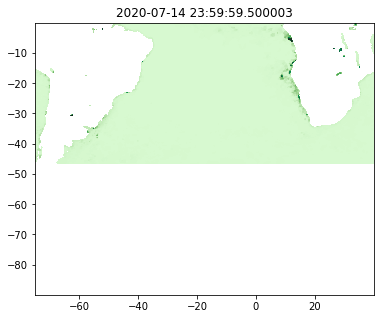

In [61]:
fig = plt.figure(figsize = (10,14))
ax0 = fig.add_axes([0.17,0.35,0.47,0.27])
slice=300
#cfT=ax0.contourf(chl_satellite.lat,chl_satellite.lon,chl_satellite.npp[20],10, cmap = cmocean.cm.algae)
cfT=ax0.contourf(chl_satellite.lon,chl_satellite.lat,chl_satellite.chl[slice].T,300, cmap = cmocean.cm.algae)
plt.title(datezz[slice])

In [63]:
chl_satellite.chl[0,0,0].values
chl_satellite.chl.size

## make mean npp across timeseries
#ignoring nans
npp_mean=chl_satellite.chl.mean(dim="date",skipna=True)

(-20.0, 0.0)

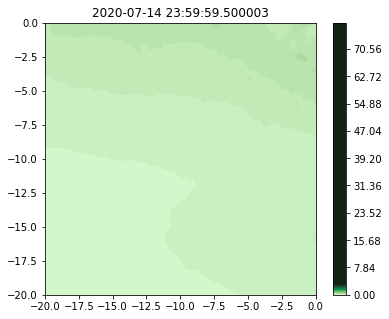

In [109]:
fig = plt.figure(figsize = (10,14))
ax0 = fig.add_axes([0.17,0.35,0.47,0.27])
slice=300
#cfT=ax0.contourf(chl_satellite.lat,chl_satellite.lon,chl_satellite.npp[20],10, cmap = cmocean.cm.algae)
cfT=ax0.contourf(chl_satellite.lon,chl_satellite.lat,npp_mean.T,1000, cmap = cmocean.cm.algae)
#cbar = fig.colorbar(contourf_)
cfT.set_clim( 0,3 )
cbar = fig.colorbar(cfT)

plt.title(datezz[slice])
ANDbox=pd.read_csv('../data/processed/ANDREXbox.csv',header=None).values
box = ax0.plot([ANDbox[:,0]],[ANDbox[:,1]],color='magenta', marker=',', linestyle='dashed',linewidth=1.5, markersize=1.5)

ax0.set_xlim(-20, 0)
ax0.set_ylim(-20, 0)

In [103]:
float_ID

array(['5904397', '5904467', '5904468', '5904471', '5904472', '5905991',
       '5905992', '5905993', '5905994', '5905995', '5906033', '5906034'],
      dtype='<U32')

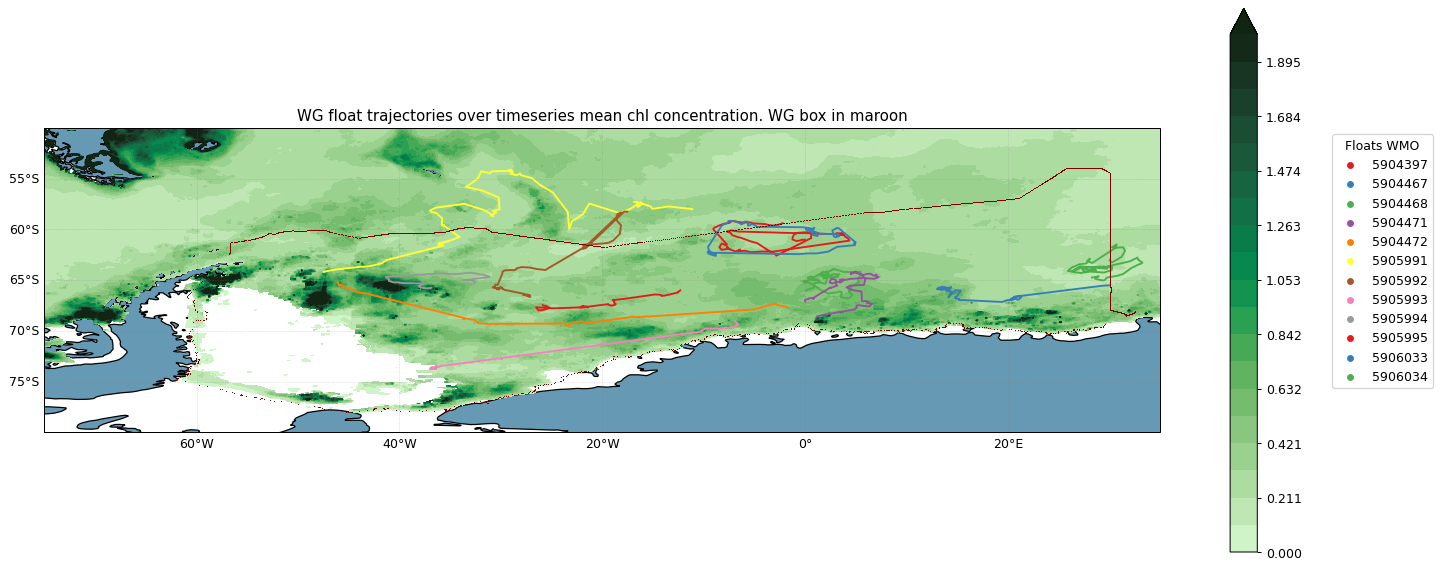

In [117]:
#!pip install argopy
from argopy import IndexFetcher as ArgoIndexFetcher
#fig, ax = plt.subplots(figsize = (20, 8))
#for n, float_ in enumerate(float_ID[0:1]):
fid=float_ID[:].tolist()
idx = ArgoIndexFetcher().float(float_ID).load() #float(fid)
fig, ax = idx.plot('trajectory', figsize=(20, 8))
levels = np.linspace(0.0, 2.0, 20)
cont=ax.contourf(chl_satellite.lon,chl_satellite.lat,npp_mean.T,levels=levels, cmap = cmocean.cm.algae,extend='max')
cont.set_clim(vmin=0, vmax=2)
cbar = fig.colorbar(cont)
box = ax.plot([ANDbox[:,0]],[ANDbox[:,1]],color='maroon', marker=',', linestyle='dashed',linewidth=10, markersize=10)
ax.set_xlim(-75,35)
ax.set_ylim(-80, -50)
strtxt='WG float trajectories over timeseries mean chl concentration. WG box in maroon'
ax.set_title(strtxt)

fig.savefig("FloatTrajChl.pdf", dpi=300, format='pdf', transparent=True)

In [ ]:
## work out how to plot trajectory with color for data overlaid
from argopy import IndexFetcher as ArgoIndexFetcher
#fig, ax = plt.subplots(figsize = (20, 8))
#for n, float_ in enumerate(float_ID[0:1]):
fid=float_ID[:].tolist()
idx = ArgoIndexFetcher().float(float_ID).load() #float(fid)
fig, ax = idx.plot('trajectory', figsize=(20, 8))
levels = np.linspace(0.0, 2.0, 20)
cont=ax.contourf(chl_satellite.lon,chl_satellite.lat,npp_mean.T,levels=levels, cmap = cmocean.cm.algae,extend='max')
cont.set_clim(vmin=0, vmax=2)
cbar = fig.colorbar(cont)
box = ax.plot([ANDbox[:,0]],[ANDbox[:,1]],color='maroon', marker=',', linestyle='dashed',linewidth=3, markersize=3)
ax.set_xlim(-75,35)
ax.set_ylim(-80, -50)
ax.title('WG float trajectories over timeseries mean chl concentration')

savefig(FloatTrajChl, dpi=300, format='pdf', transparent=True)


plt.scatter(x, y, c=t)